# Clustering des états

Utilisation des vecteurs de pertes de production et du 
Critère de DB pour les états


## Imports, extractions et nettoyage des données

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from tqdm.notebook import tqdm, trange
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler,normalize
from kmodes.kprototypes import KPrototypes
# import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")


#Our own librabries
import sys
sys.path.insert(1, '../../Environnement/')
from utils import clean_data_state, add_Loss, regroupe_crop, add_climate_clusters,add_crop_categories
import clean
import merge

In [2]:
#Select the dataset of one season of one year
YEAR = 2019
SEASON = "Rabi" # or "Kharif" 

#Path to the dataset
pathData_R = f"..\..\Data\RawDataUnified\RawData_{YEAR}_Rabi"
pathData_K= f"..\..\Data\RawDataUnified\RawData_{YEAR}_Kharif"


df_R = pd.read_csv(pathData_R)
df_K=pd.read_csv(pathData_K)

In [3]:
#Clean an add loss to data
df_R=add_Loss(clean_data_state(add_crop_categories(df_R, rabi=True)))
df_K=add_Loss(clean_data_state(add_crop_categories(df_K, rabi=False)))

df_R = add_climate_clusters(df_R, rabi=True)
df_K = add_climate_clusters(df_K, rabi=False)

df_R.head()

,State,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),crop_categories,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,Loss,climate_clusters
key,,,,,,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,Andhra Pradesh,179.859471,160.816527,30000.0,Legumineuses,0.014822,0.0,0.0,0.000000,0.882341,0.645266,0.000000,1.078638e+05,2
andhra pradesh_anantapur_vajrakarur___,Andhra Pradesh,179.859471,160.816527,30000.0,Legumineuses,0.000000,0.0,0.0,0.000000,0.217446,0.000000,0.347871,0.000000e+00,2
andhra pradesh_anantapur_gooty___,Andhra Pradesh,179.859471,160.816527,30000.0,Legumineuses,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06,2
andhra pradesh_anantapur_guntakal___,Andhra Pradesh,179.859471,160.816527,30000.0,Legumineuses,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06,2
andhra pradesh_anantapur_pamidi___,Andhra Pradesh,179.859471,160.816527,30000.0,Legumineuses,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,1.516659e+06,2


In [7]:
#data for Davis_Bouldin criteria and for clustering : sans normalisation
collumns_db = [f'Lp_{i}' for i in range(2011,2018)] # colonnes : que les lp
collumns_db.append("State")
data_R_db=df_R[collumns_db]
data_K_db=df_K[collumns_db]
data_R_db.head()

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,State
key,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,0.014822,0.0,0.0,0.000000,0.882341,0.645266,0.000000,Andhra Pradesh
andhra pradesh_anantapur_vajrakarur___,0.000000,0.0,0.0,0.000000,0.217446,0.000000,0.347871,Andhra Pradesh
andhra pradesh_anantapur_gooty___,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,Andhra Pradesh
andhra pradesh_anantapur_guntakal___,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,Andhra Pradesh
andhra pradesh_anantapur_pamidi___,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,Andhra Pradesh


In [ ]:
liste_state_R = pd.unique(data_R_db['State'])
liste_state_K = pd.unique(data_K_db['State'])

## K-prototypes

In [4]:
from kmodes.kprototypes import KPrototypes

In [1]:
def categorical_dissimilarity(a, b, **_):
    """Dissimilarity function with state penalization"""
    return (a[:,0] != b[0])*9*10**15

categorical_columns = [7]
def get_liste_state_cluster_2(clusters,donnees):
    df2 = donnees.copy(deep = True)
    df2["Cluster"] = clusters
    list_state = pd.unique(donnees["State"])
    liste_state_cluster = {}
    for i in range(len(list_state)):
        liste_state_cluster[list_state[i]] = np.bincount(df2[df2["State"] == list_state[i]]["Cluster"].to_numpy().astype(int)).argmax()
    return liste_state_cluster



Rabi

In [10]:
score_R_proto = []
clusters_R_proto = []
for i in range(2,8) : 
    nb_clusters_R = i
    #Clustering with nb_clusters_R clusters
    kproto = KPrototypes(n_clusters= nb_clusters_R, init='Cao', n_jobs = -1,cat_dissim=categorical_dissimilarity)
    clusters = kproto.fit_predict(data_R_db, categorical=categorical_columns)

    new_df = data_R_db.copy(deep = True)
    new_df['Label'] = clusters
    new_df['State_Label'] = new_df.groupby(new_df['State'])['Label'].transform(lambda x: x.value_counts().idxmax())
    #creating the labels for each state
    #dic_cluster = get_liste_state_cluster_2(clusters,df_R)
    #labels = [dic_cluster[x] for x in df_R["State"].to_numpy()]

    labels = new_df["State_Label"].to_numpy()
    clusters_R_proto.append(labels)
    if np.size(np.unique(labels)) > 1:
        #calculating the davies_bouldin_score
        db_index = davies_bouldin_score(data_R_db.drop(columns=["State"]), labels)
        score_R_proto.append(db_index)
    else:
        db_index = 10
        score_R_proto.append(db_index)
    print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

db index for Rabi with k = 2 :  2.2231795376889405


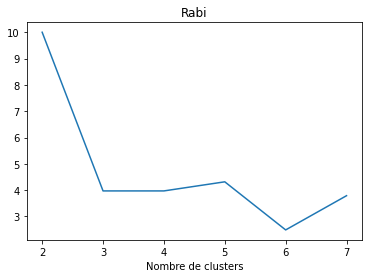

In [9]:
plt.plot(range(2,8),score_R_proto)
plt.xlabel("Nombre de clusters")
plt.title("Rabi")
plt.show()

In [34]:
cluster_R = clusters_R[4]
for i,x in enumerate(cluster_R):
    if(x==5):
        cluster_R[i] = 1 

cluster_R = np.array(cluster_R)

Kharif

In [13]:
score_K_proto = []
clusters_K_proto = []
for i in range(2,8) : 
    nb_clusters_K = i
    #Clustering with nb_clusters_K clusters
    kproto = KPrototypes(n_clusters= nb_clusters_K, init='Cao', n_jobs = -1,cat_dissim=categorical_dissimilarity)
    clusters = kproto.fit_predict(data_K_db, categorical=categorical_columns)

    #creating the labels for each state
    dic_cluster = get_liste_state_cluster_2(clusters,df_K)
    labels = [dic_cluster[x] for x in df_K["State"].to_numpy()]
    clusters_K_proto.append(labels)
    if np.size(np.unique(labels)) > 1:
        #calculating the davies_bouldin_score
        db_index = davies_bouldin_score(data_K_db.drop(columns=["State"]), labels)
        score_K_proto.append(db_index)
    else:
        db_index = 10
        score_K_proto.append(db_index)
    print(f"db index for Kharif with k = {nb_clusters_K} : ", db_index)

db index for Kharif with k = 2 :  10
db index for Kharif with k = 3 :  6.808108070327905
db index for Kharif with k = 4 :  6.808108070327905
db index for Kharif with k = 5 :  5.046854589138932
db index for Kharif with k = 6 :  3.4192403659957127
db index for Kharif with k = 7 :  4.047276143339458


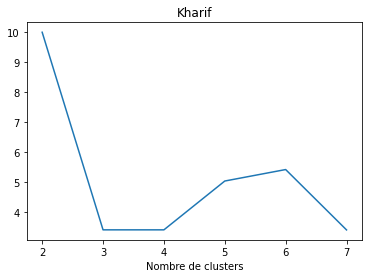

In [11]:
plt.plot(range(2,8),score_K_proto)
plt.xlabel("Nombre de clusters")
plt.title("Kharif")
plt.show()

## GMM

On applique GMM sur les vecteurs lp puis on affecte à chaque état le cluster le plus probable (celui qui maximise la somme des probas)

In [12]:
from sklearn.mixture import GaussianMixture
df_R_db_sans_etat = data_R_db.drop(columns = ["State"])
df_K_db_sans_etat = data_K_db.drop(columns = ["State"])

In [61]:
n_cluster_max = 8
score_R_GMM = []
clusters_R_GMM = []
n_init = 10

for k in range(2,n_cluster_max) : 
    nb_clusters_R = k
    clusters = []
    score = 11
    for j in range(n_init):
        #Clustering with nb_clusters_R clusters
        gm = GaussianMixture(n_components=nb_clusters_R,covariance_type = 'tied')
        gm.fit(df_R_db_sans_etat)
        prob = gm.predict_proba(df_R_db_sans_etat)

        #creating the labels for each state
        df_copy = data_R_db.copy(deep = True)
        sum_proba_state = np.zeros((np.size(liste_state_R),nb_clusters_R))
        for i in range(nb_clusters_R):
            df_copy["cluster"+str(i)] = np.log(prob[:,i])
            for j,state in enumerate(liste_state_R):
                sum_proba_state[j,i] = df_copy[df_copy["State"]==state]["cluster"+str(i)].sum()
        clusters_state = [np.argmax(sum_proba_state[i,:]) for i in range(np.size(liste_state_R))]
        clusters_state_dict = {}
        for i,state in enumerate(liste_state_R):
            clusters_state_dict[state] = clusters_state[i]
        labels = [clusters_state_dict[state] for state in data_R_db["State"].to_numpy()]

        if np.size(np.unique(labels)) > 1 and not(1 in np.bincount(clusters_state) or 2 in np.bincount(clusters_state)):
            #calculating the davies_bouldin_score
            db_index = davies_bouldin_score(df_R_db_sans_etat, labels)
        else:
            db_index = 10
            
        if(db_index<score):
            score = db_index
            clusters = labels

    score_R_GMM.append(score)
    clusters_R_GMM.append(clusters)
    print(f"db index for Rabi with k = {nb_clusters_R} : ", score)

db index for Rabi with k = 2 :  10
db index for Rabi with k = 3 :  10
db index for Rabi with k = 4 :  10
db index for Rabi with k = 5 :  10
db index for Rabi with k = 6 :  10
db index for Rabi with k = 7 :  10


In [57]:
data_copy = df_R.copy(deep = True)
data_copy["Cluster"] = clusters_R_GMM[0]

In [58]:
l = []
for state in liste_state_R:
    cluster = int(data_copy[data_copy["State"] == state]["Cluster"].mean())
    l.append([state,cluster])
l

[['Andhra Pradesh', 1],
 ['Chhattisgarh', 0],
 ['Gujarat', 1],
 ['Haryana', 1],
 ['Karnataka', 1],
 ['Madhya Pradesh', 0],
 ['Maharashtra', 1],
 ['Odisha', 1],
 ['Rajasthan', 1],
 ['Tamil Nadu', 1],
 ['Telangana', 1],
 ['Uttar Pradesh', 1],
 ['West Bengal', 1]]

In [59]:
l = [['Andhra Pradesh', 0],
 ['Chhattisgarh', 1],
 ['Gujarat', 0],
 ['Haryana', 0],
 ['Karnataka', 1],
 ['Madhya Pradesh', 1],
 ['Maharashtra', 0],
 ['Odisha', 0],
 ['Rajasthan', 0],
 ['Tamil Nadu', 0],
 ['Telangana', 0],
 ['Uttar Pradesh', 0],
 ['West Bengal', 0]]

In [60]:
clusters_state_dict = {l[i][0]:l[i][1] for i in range(len(l))}
labels = [clusters_state_dict[state] for state in data_R_db["State"].to_numpy()]
davies_bouldin_score(df_R_db_sans_etat, labels)

4.341590024430636

In [37]:
n_cluster_max = 10
score_K_GMM = []
clusters_K_GMM = []
n_init = 10

for k in range(2,n_cluster_max) : 
    nb_clusters_K = k
    clusters = []
    score = 11
    for j in range(n_init):
        #Clustering with nb_clusters_K clusters
        gm = GaussianMixture(n_components=nb_clusters_K,covariance_type = 'tied')
        gm.fit(df_K_db_sans_etat)
        prob = gm.predict_proba(df_K_db_sans_etat)

        #creating the labels for each state
        df_copy = data_K_db.copy(deep = True)
        sum_proba_state = np.zeros((np.size(liste_state_K),nb_clusters_K))
        for i in range(nb_clusters_K):
            df_copy["cluster"+str(i)] = np.log(prob[:,i])
            for j,state in enumerate(liste_state_K):
                sum_proba_state[j,i] = df_copy[df_copy["State"]==state]["cluster"+str(i)].sum()
        clusters_state = [np.argmax(sum_proba_state[i,:]) for i in range(np.size(liste_state_K))]
        clusters_state_dict = {}
        for i,state in enumerate(liste_state_K):
            clusters_state_dict[state] = clusters_state[i]
        labels = [clusters_state_dict[state] for state in data_K_db["State"].to_numpy()]

        if np.size(np.unique(labels)) > 1 and not(np.size(np.unique(labels))==2 and 1 in np.bincount(clusters_state)):
            #calculating the davies_bouldin_score
            db_index = davies_bouldin_score(df_K_db_sans_etat, labels)
        else:
            db_index = 10
        if(db_index<score):
            score = db_index
            clusters = labels

    score_K_GMM.append(score)
    clusters_K_GMM.append(clusters)
    print(f"db index for Kharif with k = {nb_clusters_K} : ", score)

db index for Kharif with k = 2 :  10
db index for Kharif with k = 3 :  3.4217989011183283
db index for Kharif with k = 4 :  3.4217989011183283
db index for Kharif with k = 5 :  3.4217989011183283
db index for Kharif with k = 6 :  3.4217989011183283
db index for Kharif with k = 7 :  10
db index for Kharif with k = 8 :  10
db index for Kharif with k = 9 :  10


In [53]:
data_copy = df_K.copy(deep = True)
data_copy["Cluster"] = clusters_K_GMM[1]

In [55]:
l = []
for state in liste_state_K:
    cluster = int(data_copy[data_copy["State"] == state]["Cluster"].mean())
    l.append([state,cluster])
l

[['Andhra Pradesh', 1],
 ['Chhattisgarh', 1],
 ['Gujarat', 1],
 ['Haryana', 1],
 ['Jharkhand', 0],
 ['Karnataka', 1],
 ['Madhya Pradesh', 0],
 ['Maharashtra', 1],
 ['Odisha', 1],
 ['Rajasthan', 1],
 ['Telangana', 1],
 ['Uttar Pradesh', 1],
 ['Uttarakhand', 1],
 ['West Bengal', 1]]

## K-Prototypes avec Crop et State

In [6]:
from kmodes.kprototypes import KPrototypes

In [7]:
#data for clustering 
collumns = [f'Lp_{i}' for i in range(2011,2018)] # colonnes : que les lp
collumns.append("State")
collumns.append("Crop")
data_R=regroupe_crop(df_R[collumns])
data_K=regroupe_crop(df_K[collumns])
data_R.head()

,Lp_2011,Lp_2012,Lp_2013,Lp_2014,Lp_2015,Lp_2016,Lp_2017,State,Crop
key,,,,,,,,,
andhra pradesh_anantapur_vidapanakal___,0.014822,0.0,0.0,0.000000,0.882341,0.645266,0.000000,Andhra Pradesh,Bengal Gram (Chana)
andhra pradesh_anantapur_vajrakarur___,0.000000,0.0,0.0,0.000000,0.217446,0.000000,0.347871,Andhra Pradesh,Bengal Gram (Chana)
andhra pradesh_anantapur_gooty___,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,Andhra Pradesh,Bengal Gram (Chana)
andhra pradesh_anantapur_guntakal___,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,Andhra Pradesh,Bengal Gram (Chana)
andhra pradesh_anantapur_pamidi___,0.330642,0.0,0.0,0.086273,0.000000,0.496653,0.122131,Andhra Pradesh,Bengal Gram (Chana)


In [13]:
pen_state = 10**10
pen_crop  = 10**3 
def categorical_dissimilarity(a, b, **_):
    """Dissimilarity function with state penalization"""
    return (a[:,0] != b[0])*pen_state + (a[:,1] != b[1])*pen_crop

categorical_columns = [7,8]

 Rabi

In [14]:
score_R_proto = []
clusters_R_proto = []
for i in range(2,8) : 
    nb_clusters_R = i
    #Clustering with nb_clusters_R clusters
    kproto = KPrototypes(n_clusters=nb_clusters_R, init='Cao', n_jobs=-1, cat_dissim=categorical_dissimilarity, n_init=1, random_state=1)
    clusters = kproto.fit_predict(data_R, categorical=categorical_columns)

    #creating the labels for each state
    new_df = data_R_db.copy(deep=True)
    new_df['Label'] = clusters
    new_df['State_Label'] = new_df.groupby(new_df['State'])['Label'].transform(lambda x: x.value_counts().idxmax())
    #dic_cluster = get_liste_state_cluster_2(clusters,df_R)
    #labels = [dic_cluster[x] for x in df_R["State"].to_numpy()]

    labels = new_df["State_Label"].to_numpy()
    clusters_R_proto.append(labels)
    if np.size(np.unique(labels)) > 1:
        #calculating the davies_bouldin_score
        db_index = davies_bouldin_score(data_R_db.drop(columns=["State"]), labels)
        score_R_proto.append(db_index)
    else:
        db_index = 10
        score_R_proto.append(db_index)
    print(f"db index for Rabi with k = {nb_clusters_R} : ", db_index)

Kharif

In [11]:
score_K_proto = []
clusters_K_proto = []
for i in range(2,8) : 
    nb_clusters_K = i
    #Clustering with nb_clusters_K clusters
    kproto = KPrototypes(n_clusters=nb_clusters_K, init='Cao', n_jobs=-1, cat_dissim=categorical_dissimilarity, n_init=1, random_state=1)
    clusters = kproto.fit_predict(data_K, categorical=categorical_columns)

    #creating the labels for each state
    new_df = data_K_db.copy(deep=True)
    new_df['Label'] = clusters
    new_df['State_Label'] = new_df.groupby(new_df['State'])['Label'].transform(lambda x: x.value_counts().idxmax())
    #dic_cluster = get_liste_state_cluster_2(clusters,df_R)
    #labels = [dic_cluster[x] for x in df_R["State"].to_numpy()]

    labels = new_df["State_Label"].to_numpy()
    clusters_K_proto.append(labels)
    if np.size(np.unique(labels)) > 1:
        #calculating the davies_bouldin_score
        db_index = davies_bouldin_score(data_K_db.drop(columns=["State"]), labels)
        score_K_proto.append(db_index)
    else:
        db_index = 10
        score_K_proto.append(db_index)
    print(f"db index for Kabi with k = {nb_clusters_K} : ", db_index)

db index for Kabi with k = 2 :  10
